In [1]:
from src.models import *
from tqdm import tqdm

# 定义网格大小
Ns = (11, 11, 11)  # 三维网格每个维度的点数
N_vec = Ns[0]*Ns[1]*Ns[2]  # 总网格点数

# 创建单位矩阵
eye = np.eye(N_vec)  # N_vec x N_vec 的单位矩阵

# 定义物理参数
Ls = (1, 1, 1)  # 三个维度的长度
beta = 0.1  # 温度的倒数
max_iter = 20  # 最大迭代次数
eval_iter = 3  # 评估迭代次数
mu = 0
energy_list_scf = []
ks = [np.linspace(0, Ns[i]-1, Ns[i])*Ls[i]/Ns[i] for i in range(3)]
Ks = np.meshgrid(*ks, indexing='ij')
D = -np.array(sum([np.sqrt(1/(np.cos(Ks[i]*4*np.pi/Ls[i])+1) + 0.3*0.3) for i in range(3)]))
# D = D.reshape([Ns[0]*Ns[1]*Ns[2], 1])
potential_external = D
# density_scf = 1/(1+np.exp(beta*D))


ham = deterministicHamiltonian(Ns, Ls,beta)
ham.update_external(potential_external)

# C = np.diag(D.flatten())
X_scf = np.eye(N_vec)/2
C = ham.C

for i in tqdm(range(max_iter)):
    prev_X_scf = X_scf
    new_ham = C + np.diag(ham.potential_yukawa(np.diag(X_scf))) - mu* eye
    # new_ham = C - mu* eye
    eigvals, eigvecs = np.linalg.eigh(new_ham)
    # print(eigvals)
    # print(np.linalg.norm( eigvecs @ np.diag(eigvals) @ eigvecs.T - new_ham))
    # eigvals = np.clip(eigvals, -200, 200)
    eigvals = 1/(1+ np.exp(beta*eigvals))
    X_scf = eigvecs @ np.diag(eigvals) @ eigvecs.T
    
print(np.linalg.norm(X_scf - prev_X_scf))

100%|██████████| 20/20 [00:10<00:00,  1.90it/s]

2.6385259013728307e-14


In [12]:
print(np.linalg.norm(np.diag(X_scf) -1/(1+np.exp(beta*D.flatten())) ))


0.0


(2.326763929990579+0j)


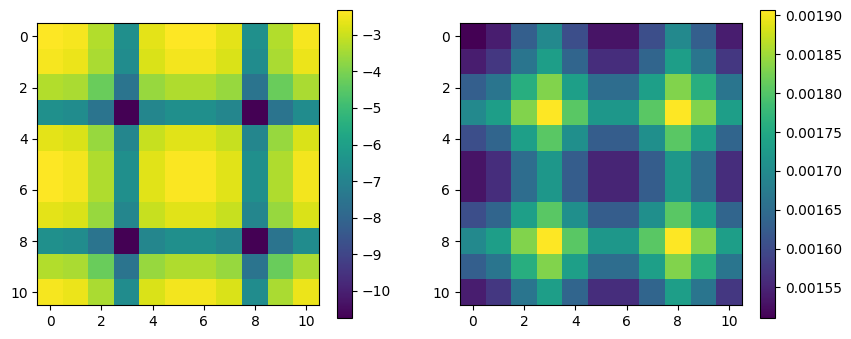

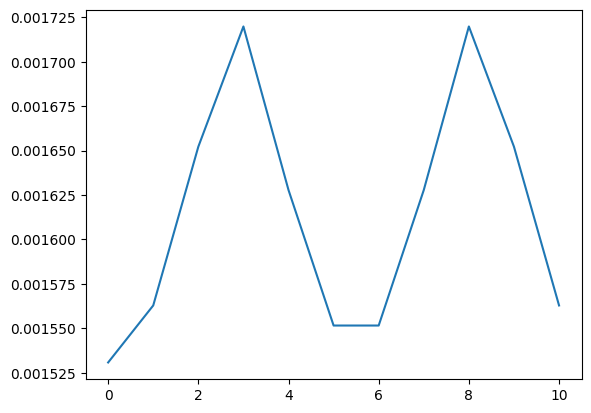

In [4]:
# Plots 
density_scf = np.diag(X_scf)
print(sum(density_scf))
plt.figure(figsize=(10,4))
potential_external = ham.potential_external.reshape(Ns)
plt.subplot(1,2,1)
plt.imshow(potential_external[6,:,:])
plt.colorbar()

plt.subplot(1,2,2)
density_scf = density_scf.reshape(Ns).real
plt.imshow(density_scf[5,:,:])
plt.colorbar()
plt.show()


plt.figure()
plt.plot(density_scf[5,5,:])
plt.show()

In [42]:
from src.models import *
from tqdm import tqdm

# Ns = (11, 11, 11)
# N_vec = Ns[0]*Ns[1]*Ns[2]
# Ls = (1, 1, 1)
# beta = 0.5
max_iter = 1000
eval_iter = 10
# mu = 10
# objectives = np.zeros([7, max_iter//eval_iter])

# # Generate the external potential
# Ls = np.array(Ls)
# Ns = np.array(Ns)

# ks = [np.linspace(0, Ns[i]-1, Ns[i])*Ls[i]/Ns[i] for i in range(3)]
# Ks = np.meshgrid(*ks, indexing='ij')
# D = -np.array(sum([np.sqrt(1/(np.cos(Ks[i]*4*np.pi/Ls[i])+1) + 0.3*0.3) for i in range(3)]))
# D = D.reshape([Ns[0]*Ns[1]*Ns[2], 1])
# potential_external = D


# ham = deterministicHamiltonian(Ns, Ls,beta)
# ham.update_external(potential_external)

H = np.zeros([N_vec, N_vec])
eye = np.eye(N_vec)
# H = jnp.array(H)
lr = 0.1/beta
iter = 1
iter_eval = 0
iter_eval_list = []
density_scf = density_scf.reshape(N_vec)

# while iter <= max_iter:
# for iter in tqdm(range(max_iter)):
for iter in range(max_iter):

    gradient = ham.gradient(H)
    # effective_lr = lr/(lr + beta * np.sqrt(iter))
    effective_lr = lr
    H = (1-effective_lr)*H + effective_lr*(gradient - mu*eye)
    if iter % eval_iter == 0:
        density_DMD = ham.density_function(H)
        print(f"Iteration {iter}, Density errior {np.linalg.norm(density_DMD - density_scf)}")
        # objectives[:, iter_eval] = np.array(ham.objective(H))
        # print(f"Iteration {iter}, Objective {objectives[:, iter_eval]}")
        # iter_eval += 1
        # iter_eval_list.append(iter)



Iteration 0, Density errior 0.041741607316185494
Iteration 10, Density errior 0.00043337775640834685
Iteration 20, Density errior 4.741943194394122e-05
Iteration 30, Density errior 5.099187100733865e-06
Iteration 40, Density errior 5.476056080952559e-07
Iteration 50, Density errior 5.87996527446855e-08
Iteration 60, Density errior 6.313557709022374e-09
Iteration 70, Density errior 6.778951293502734e-10
Iteration 80, Density errior 7.276036666324913e-11
Iteration 90, Density errior 7.78326958001919e-12
Iteration 100, Density errior 8.162109422961986e-13
Iteration 110, Density errior 8.900236811735402e-14
Iteration 120, Density errior 5.6072816089308047e-14
Iteration 130, Density errior 6.307396880979317e-14
Iteration 140, Density errior 6.048297543411989e-14
Iteration 150, Density errior 6.140987722388351e-14
Iteration 160, Density errior 5.97597663966848e-14
Iteration 170, Density errior 6.258924281413523e-14
Iteration 180, Density errior 6.003848157276978e-14
Iteration 190, Density er

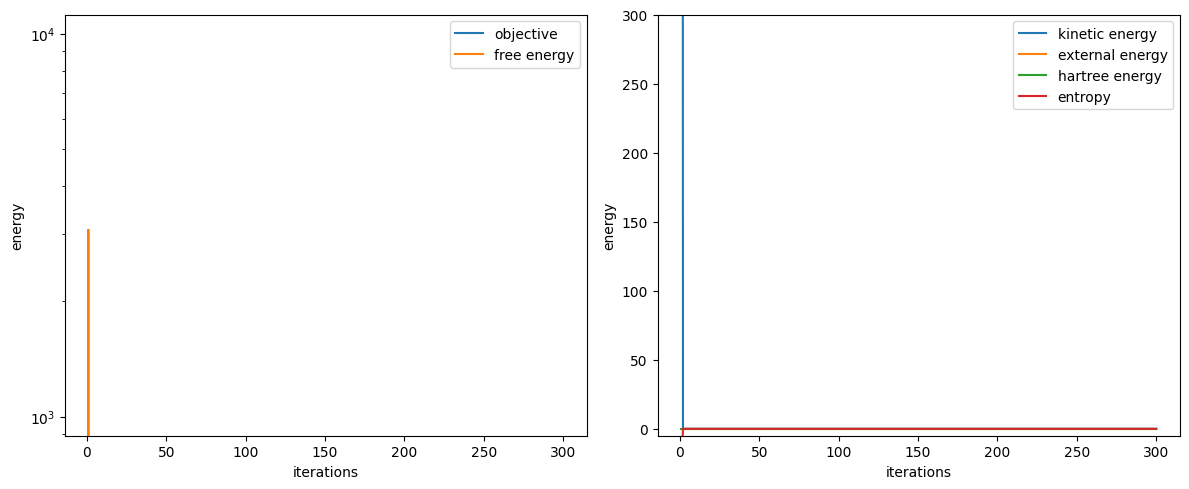

In [2]:
plt.figure(figsize=(12,5),dpi=100)
plt.subplot(1,2,1)
iters = np.linspace(1, max_iter, max_iter)
plt.semilogy(iters, objectives[0,:], label="objective")
plt.plot(iters, objectives[1,:], label='free energy')
plt.xlabel("iterations")
plt.ylabel("energy")
plt.legend()

plt.subplot(1,2,2)
plt.plot(iters, objectives[2,:], label="kinetic energy")
plt.plot(iters, objectives[3,:], label="external energy")
plt.plot(iters, objectives[4,:], label="hartree energy")
plt.plot(iters, objectives[5,:], label="entropy")
plt.ylim([-5,300])
plt.xlabel("iterations")
plt.ylabel("energy")

plt.legend()
plt.tight_layout()
plt.show()

(4.195791306278138+0j)


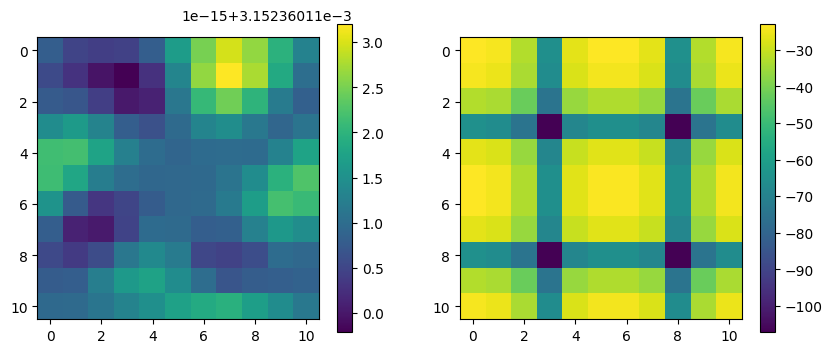

In [40]:
density = ham.density_function(H)
print(sum(density))
external_potential = ham.potential_external 
external_potential = external_potential.reshape(Ns) 

density = density.reshape(Ns)
density = np.real(density)
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.imshow(density[99,:,:])
plt.colorbar()

plt.subplot(1,2,2)
plt.imshow(external_potential[0,:,:])
plt.colorbar()
plt.show()